# Model Training Script 

In [19]:
# Required Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling Libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Ignore warnings
import warnings

In [2]:
# Load CSVs
df_16 = pd.read_csv("data/coin_gecko_2022-03-16.csv")
df_17 = pd.read_csv("data/coin_gecko_2022-03-17.csv")

# Combine both
df = pd.concat([df_16, df_17], ignore_index=True)

# first five rows
df.head()

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


In [3]:
# fill NaN values
df['1h'].fillna(df['1h'].mean(), inplace=True)
df['24h'].fillna(df['24h'].mean(), inplace=True)
df['7d'].fillna(df['7d'].mean(), inplace=True)
df['24h_volume'].fillna(df['24h_volume'].mean(), inplace=True)

C:\Users\jayta\AppData\Local\Temp\ipykernel_9404\480933773.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['1h'].fillna(df['1h'].mean(), inplace=True)
C:\Users\jayta\AppData\Local\Temp\ipykernel_9404\480933773.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

## Feature Engineering

In [4]:
# Calculate the liquidity score
df['liquidity_score'] = df['24h_volume'] / df['mkt_cap']

# Price change ratio
df['price_change_ratio'] = df['24h'] / df['price']

# Volume to price
df['volume_to_price'] = df['24h_volume'] / df['price']

# Stable coin feature
stable_coins = ['USDT', 'USDC', 'BUSD']
df['is_stable_coin'] = df['symbol'].apply(lambda x: 1 if x in stable_coins else 0)

In [7]:
# preparing x and Y variables

x = df[['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap',
        'price_change_ratio', 'volume_to_price', 'is_stable_coin']]

Y = df['liquidity_score']

In [8]:
x.head()

,price,1h,24h,7d,24h_volume,mkt_cap,price_change_ratio,volume_to_price,is_stable_coin
0,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,7.342241e-07,8.661584e+05,0
1,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,1.238882e-05,7.195971e+06,0
2,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,-1.000000e-03,5.793497e+10,1
3,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,7.302506e-05,3.640440e+06,0
4,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,0.000000e+00,3.872762e+09,1


In [14]:
# create column Transformer with 3 types of transformers
num_features = x.select_dtypes(exclude="object").columns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [("StandardScaler", numeric_transformer, num_features)]
)

In [15]:
x = preprocessor.fit_transform(x)

In [16]:
# seperate the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((800, 9), (200, 9))

## Create an evaluation Function to give all metrics after model training

In [23]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

In [24]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # Train the model

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluate the model
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model Performance on Training Set:')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('--------------------------------')

    print('Model Performance on Testing Set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model Performance on Training Set:
- Root Mean Squared Error: 0.4136
- Mean Absolute Error: 0.1418
- R2 Score: 0.1701
--------------------------------
Model Performance on Testing Set
- Root Mean Squared Error: 0.3504
- Mean Absolute Error: 0.1285
- R2 Score: -0.0379


Lasso Regression
Model Performance on Training Set:
- Root Mean Squared Error: 0.4540
- Mean Absolute Error: 0.1534
- R2 Score: 0.0000
--------------------------------
Model Performance on Testing Set
- Root Mean Squared Error: 0.3444
- Mean Absolute Error: 0.1278
- R2 Score: -0.0027


Ridge Regression
Model Performance on Training Set:
- Root Mean Squared Error: 0.4136
- Mean Absolute Error: 0.1418
- R2 Score: 0.1701
--------------------------------
Model Performance on Testing Set
- Root Mean Squared Error: 0.3503
- Mean Absolute Error: 0.1285
- R2 Score: -0.0378


K-Neighbors Regressor
Model Performance on Training Set:
- Root Mean Squared Error: 0.3018
- Mean Absolute Error: 0.0959
- R2 Score: 0.558

## Results

In [25]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'], ascending=False)

,Model Name,R2_Score
7,CatBoost Regressor,0.987761
8,AdaBoost Regressor,0.883182
9,Gradient Boosting Regressor,0.865417
5,Random Forest Regressor,0.830857
6,XGBoost Regressor,0.595499
4,Decision Tree Regressor,0.458710
3,K-Neighbors Regressor,0.179247
10,Support Vector Regressor,0.036916
1,Lasso Regression,-0.002694
2,Ridge Regression,-0.037830


## CatBoost Regressor

In [26]:
lin_model = CatBoostRegressor(verbose=False)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print("Acuracy of the model is: {:.2f}%".format(score))

Acuracy of the model is: 98.78%


## Plot y_pred and y_test

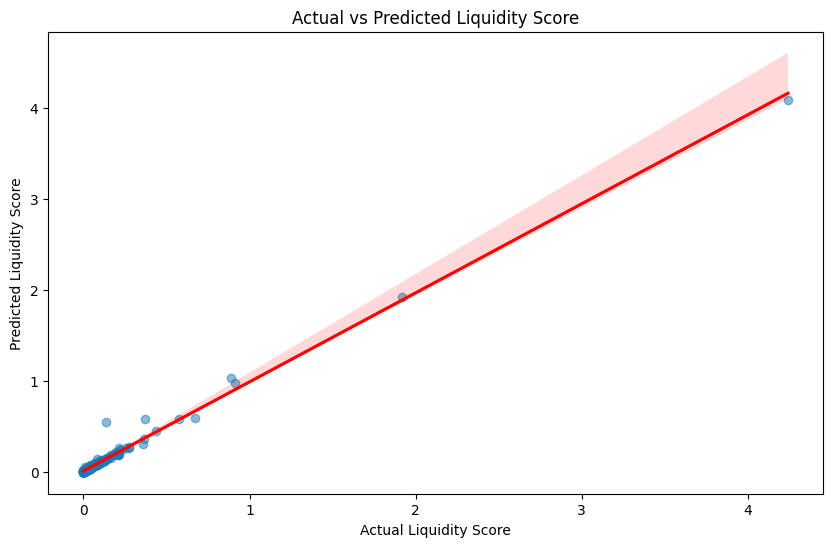

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, scatter_kws={"alpha": 0.5})
plt.xlabel("Actual Liquidity Score")
plt.ylabel("Predicted Liquidity Score")
plt.title("Actual vs Predicted Liquidity Score")
plt.show()

## Difference between Actual and Predicted Values

In [28]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred, 'Difference': y_test - y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,0.000958,-0.005701,0.006659
737,0.003165,0.002206,0.000960
740,0.038581,0.034406,0.004175
660,0.082668,0.081601,0.001066
411,0.001230,0.004102,-0.002872
...,...,...,...
408,0.009156,0.012153,-0.002996
332,0.033906,0.035528,-0.001622
208,0.043418,0.046490,-0.003072
613,0.115318,0.112077,0.003241
